In [1]:
#Data Handling
import pandas as pd
import numpy as np
import tifffile as tiff
from math import pi
import os

#Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from matplotlib.ticker import FuncFormatter

# Data Manipulation
from scipy.stats import gaussian_kde
from scipy.signal import argrelextrema
from scipy.signal import argrelmax
from scipy.signal import find_peaks
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind

In [3]:
dict_of_mutants = {
    'jRGECO1a': ['Results01','Results02','Results03','Results04','Results05','Results06'],
    'R393V': ['Results08','Results09','Results10','Results11','Results12','Results13','Results14'],
    'L415A': ['Results15','Results16','Results17','Results18'],
    'L415V': ['Results19','Results20']
}

variant_color_map = {
    'jRGECO1a': '#7ebf83',
    'R393V': '#4fa78a',
    'L415A': '#f2dea2',
    'L415V': '#e18e5c',
}

In [4]:
path_1 = "C:/Users/shuyu/Desktop/2025-02-28_jRGECO1a_neurons/"
last_bit = '.csv'
output_folder = "C:/Users/shuyu/Desktop/2025-02-28_jRGECO1a_neurons/results"
os.makedirs(output_folder, exist_ok=True)

In [37]:
df_list_F0 = []
df_list_deltaF_F0 = []
all_F0_values = {}
all_values = {}

for variant, files in dict_of_mutants.items():
    F0_variant = []
    deltaF_F0_variant = []

    for file in files:
        file_path = os.path.join(path_1, file + last_bit)
        if os.path.exists(file_path):
            df = pd.read_csv(file_path, index_col=0)
            
            for col in df.columns:
                F0 = df[col][:25].mean()
                max_deltaF = df[col][-60:].max()
                deltaF_F0 = (max_deltaF - F0) / F0

                F0_variant.append(F0)
                deltaF_F0_variant.append(deltaF_F0)

                df_list_F0.append({'variant': variant, 'F0': F0})
                df_list_deltaF_F0.append({'variant': variant, 'deltaF_F0': deltaF_F0})

    all_F0_values[variant] = F0_variant
    all_values[variant] = deltaF_F0_variant

df_plot_F0 = pd.DataFrame(df_list_F0)
df_plot_deltaF_F0 = pd.DataFrame(df_list_deltaF_F0)

df_plot_F0_filtered = df_plot_F0[df_plot_F0["F0"] <= 200]

C:\Users\shuyu\AppData\Local\Temp\ipykernel_34828\2841404308.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


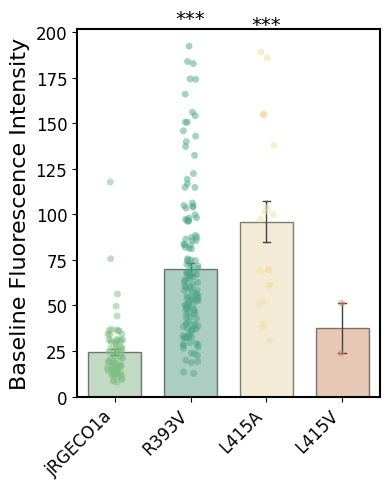

In [38]:
p_values = {}
for variant in df_plot_F0_filtered['variant'].unique():
    if variant != 'jRGECO1a':
        group_1 = df_plot_F0_filtered[df_plot_F0_filtered['variant'] == 'jRGECO1a']['F0']
        group_2 = df_plot_F0_filtered[df_plot_F0_filtered['variant'] == variant]['F0']
        
        _, p_value = ttest_ind(group_1, group_2)
        p_values[variant] = p_value

plt.figure(figsize=(4, 5))
sns.barplot(
    data=df_plot_F0_filtered, x="variant", y="F0", estimator=np.mean,
    errorbar="se", capsize=0.1, err_kws={"linewidth": 1.0},
    edgecolor="black", linewidth=1, width=0.7,
    palette=variant_color_map, alpha=0.5
)
sns.stripplot(
    data=df_plot_F0_filtered, x="variant", y="F0", hue="variant",
    palette=variant_color_map, size=5, jitter=True, alpha=0.5, dodge=False
)

for variant, p_value in p_values.items():
    y_max = df_plot_F0_filtered[df_plot_F0_filtered['variant'] == variant]['F0'].max() + 10
    if p_value < 0.001:
        plt.text(x=df_plot_F0_filtered['variant'].unique().tolist().index(variant), y=y_max, s='***', ha='center', va='bottom', fontsize=14)
    elif p_value < 0.01:
        plt.text(x=df_plot_F0_filtered['variant'].unique().tolist().index(variant), y=y_max, s='**', ha='center', va='bottom', fontsize=14)
    elif p_value < 0.05:
        plt.text(x=df_plot_F0_filtered['variant'].unique().tolist().index(variant), y=y_max, s='*', ha='center', va='bottom', fontsize=14)

ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(1.5)

plt.ylabel("Baseline Fluorescence Intensity", fontsize=16)
plt.xlabel("")
plt.yticks(fontsize=12)
plt.xticks(fontsize=12, rotation=45, ha='right', va='top')
plt.legend([], [], frameon=False)
plt.tight_layout()
output_file = os.path.join(output_folder, "Baseline_Fluorescene_Intensity.pdf")
plt.savefig(output_file, format='pdf')
plt.show()

C:\Users\shuyu\AppData\Local\Temp\ipykernel_34828\402061032.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


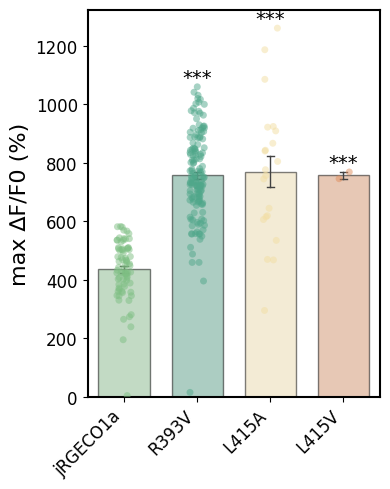

In [39]:
from matplotlib.ticker import FuncFormatter

df_plot_deltaF_F0['deltaF_F0_percent'] = df_plot_deltaF_F0['deltaF_F0'] * 100

p_values_deltaF_F0 = {}
for variant in df_plot_deltaF_F0['variant'].unique():
    if variant != 'jRGECO1a':
        group_1 = df_plot_deltaF_F0[df_plot_deltaF_F0['variant'] == 'jRGECO1a']['deltaF_F0_percent']
        group_2 = df_plot_deltaF_F0[df_plot_deltaF_F0['variant'] == variant]['deltaF_F0_percent']
        
        _, p_value = ttest_ind(group_1, group_2)
        p_values_deltaF_F0[variant] = p_value

plt.figure(figsize=(4, 5))
sns.barplot(
    data=df_plot_deltaF_F0, x="variant", y="deltaF_F0_percent", estimator=np.mean,
    errorbar="se", capsize=0.1, err_kws={"linewidth": 1.0},
    edgecolor="black", linewidth=1, width=0.7,
    palette=variant_color_map, alpha=0.5
)
sns.stripplot(
    data=df_plot_deltaF_F0, x="variant", y="deltaF_F0_percent", hue="variant",
    palette=variant_color_map, size=5, jitter=True, alpha=0.5, dodge=False
)

for variant, p_value in p_values_deltaF_F0.items():
    y_max = df_plot_deltaF_F0[df_plot_deltaF_F0['variant'] == variant]['deltaF_F0_percent'].max() + 0.1  # 上移显示 p 值
    if p_value < 0.001:
        plt.text(x=df_plot_deltaF_F0['variant'].unique().tolist().index(variant), y=y_max, s='***', ha='center', va='bottom', fontsize=14)
    elif p_value < 0.01:
        plt.text(x=df_plot_deltaF_F0['variant'].unique().tolist().index(variant), y=y_max, s='**', ha='center', va='bottom', fontsize=14)
    elif p_value < 0.05:
        plt.text(x=df_plot_deltaF_F0['variant'].unique().tolist().index(variant), y=y_max, s='*', ha='center', va='bottom', fontsize=14)

ax = plt.gca()
#ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.1f}%'))

for spine in ax.spines.values():
    spine.set_linewidth(1.5)

plt.ylabel("max ∆F/F0 (%)", fontsize=16)
plt.xlabel("")
plt.yticks(fontsize=12)
plt.xticks(fontsize=12, rotation=45, ha='right', va='top')
plt.legend([], [], frameon=False)
plt.tight_layout()
output_file = os.path.join(output_folder, "max F-F (percent).pdf")
plt.savefig(output_file, format='pdf')
plt.show()


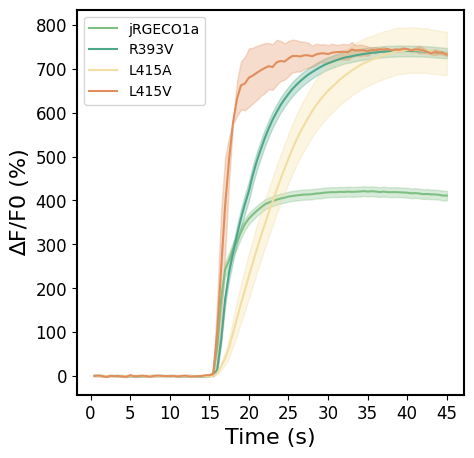

In [43]:
all_time_series = {}
all_sem_series = {}

for variant, files in dict_of_mutants.items():
    all_experiments_deltaF_F0 = []

    for file in files:
        file_path = os.path.join(path_1, file + last_bit)
        if os.path.exists(file_path):
            df = pd.read_csv(file_path, index_col=0)

            F0 = df.iloc[:30, :].mean(axis=0)
            
            deltaF_F0_series = (df - F0) / F0 * 100
            
            all_experiments_deltaF_F0.append(deltaF_F0_series)

    if all_experiments_deltaF_F0:
        combined_df = pd.concat(all_experiments_deltaF_F0, axis=1)
        mean_deltaF_F0 = combined_df.mean(axis=1)
        sem_deltaF_F0 = combined_df.sem(axis=1)
        
        all_time_series[variant] = mean_deltaF_F0
        all_sem_series[variant] = sem_deltaF_F0

plt.figure(figsize=(5, 5))

for variant, time_series in all_time_series.items():
    sem_series = all_sem_series[variant]
    color = variant_color_map.get(variant, 'black')
    
    time_in_seconds = time_series.index * 0.5  

    plt.plot(time_in_seconds, time_series.values, label=variant, color=color)
    
    plt.fill_between(time_in_seconds, 
                     time_series - sem_series, 
                     time_series + sem_series, 
                     color=color, alpha=0.3)

plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Time (s)", fontsize = 16)
plt.ylabel("∆F/F0 (%)",  fontsize = 16)
plt.legend(fontsize = 10)

max_time = max(time_in_seconds)
plt.xticks(np.arange(0, max_time + 1, 5))

ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(1.5)

output_file = os.path.join(output_folder, "Time_Series.pdf")
plt.savefig(output_file, format='pdf')
plt.show()

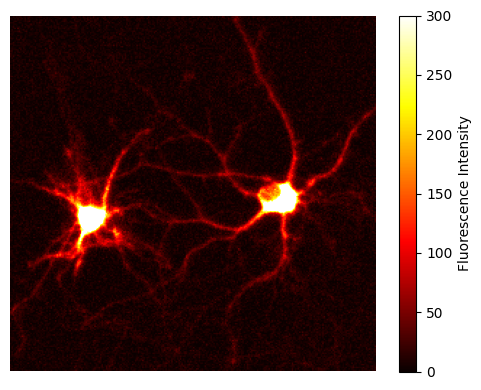

In [24]:
import tifffile
import matplotlib.pyplot as plt
import numpy as np

tif_file_path = 'C:/Users/shuyu/Desktop/2025-02-28_jRGECO1a_neurons/sample_06-1.tif'
with tifffile.TiffFile(tif_file_path) as tif:
    frame = tif.pages[69].asarray()

vmin_value = np.min(0)
vmax_value = np.max(300)

plt.figure(figsize=(5, 4))
plt.axis('off') 
plt.imshow(frame, cmap='hot', aspect='auto', vmin=vmin_value, vmax=vmax_value)
plt.colorbar(label='Fluorescence Intensity')
output_file = os.path.join(output_folder, "06.pdf")
plt.savefig(output_file, format='pdf')
plt.tight_layout()

plt.show()
